In [84]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import numpy as np
import warnings
import requests
import sqlparse
import seaborn as sns

In [85]:
warnings.filterwarnings('ignore')

In [86]:
# function to connect to wiki_dbs and query
def connect_and_query(wiki_name, query, cnf_path = "/home/paws/.my.cnf"):
    
    conn = pymysql.connect(host = wiki_name + '.analytics.db.svc.wikimedia.cloud',
                           read_default_file = cnf_path,
                           database = wiki_name + '_p')
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    
    colnames = [desc[0] for desc in cur.description]
    conn.close()
    return pd.DataFrame(data, columns=colnames)

In [87]:
wikis = ['tewiki', 'hiwiki', 'mlwiki']
all_dfs = []

Number_of_deleted_pages_and_edits

In [88]:
query_url1 = "https://raw.githubusercontent.com/yeswanth120-gif/community-insights-dashboard-tooling/main/Number_of_deleted_pages_and_edits.sql"
query1 = requests.get(query_url1).text

In [89]:
query1

'SELECT\n    DATE(ar_timestamp) AS Deletion_Date,             -- Extracts the date for dashboard filtering\n    COUNT(ar_id) AS deleted_pages                    -- Counts the number of deleted pages per day\nFROM\n    archive                                          -- Table containing records of deleted pages\nGROUP BY\n    Deletion_Date                                    -- Groups the counts by day\nORDER BY\n    Deletion_Date;                                   -- Sorts the results by date\n'

In [90]:

# ------------------ Fetch and clean SQL ------------------
response = requests.get(query_url1)
if response.status_code != 200:
    raise Exception(f"Failed to fetch query from {query_url}. Status code: {response.status_code}")

query_raw = response.text.strip()

# Clean SQL (remove comments and newlines)
cleaned_query = sqlparse.format(query_raw, strip_comments=True, reindent=False).strip()

if not cleaned_query:
    raise ValueError("SQL query is empty after cleaning. Please check the query content or URL.")

# ------------------ Execute the query across all wikis ------------------
all_dfs = []
for wiki in wikis:
    print(f"Querying: {wiki}")
    try:
        df = connect_and_query(wiki, cleaned_query)
        df['wiki'] = wiki  # Add a column to label the wiki source
        all_dfs.append(df)
    except Exception as e:
        print(f"Could not run query on {wiki}: {e}")

# ------------------ Combine and display results ------------------
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("\n--- Query Results ---\n")
    print(combined_df)
else:
    print("\nNo data was fetched from any wiki.")


Querying: tewiki
Querying: hiwiki
Querying: mlwiki

--- Query Results ---

      Deletion_Date  deleted_pages    wiki
0        2002-02-25              1  tewiki
1        2002-07-15              1  tewiki
2        2002-08-04              1  tewiki
3        2002-08-29              3  tewiki
4        2002-09-17              1  tewiki
...             ...            ...     ...
23032    2025-07-07              4  mlwiki
23033    2025-07-08              3  mlwiki
23034    2025-07-11              4  mlwiki
23035    2025-07-17              1  mlwiki
23036    2025-07-19              1  mlwiki

[23037 rows x 3 columns]


Number_of_Automated_Edits

In [91]:
query_url2 = "https://raw.githubusercontent.com/yeswanth120-gif/community-insights-dashboard-tooling/main/Number_of_Automated_Edits.sql"
query2 = requests.get(query_url2).text

In [92]:
query2

"SELECT\n    DATE(r.rev_timestamp) AS Edit_Date,              -- Extract the date for filtering on the dashboard\n    COUNT(DISTINCT r.rev_id) AS Automated_Edits      -- Count distinct edits to avoid duplicates\nFROM\n    revision AS r\nJOIN\n    actor AS a ON r.rev_actor = a.actor_id           -- Join to identify the editor (actor)\nJOIN\n    user_groups AS ug ON a.actor_user = ug.ug_user   -- Join to access user group information\nWHERE\n    ug.ug_group = 'bot'                              -- Filter for edits made only by bots\nGROUP BY\n    Edit_Date                                        -- Group results by date\nORDER BY\n    Edit_Date;                                       -- Sort the results chronologically\n"

Querying: tewiki
Querying: hiwiki
Querying: mlwiki


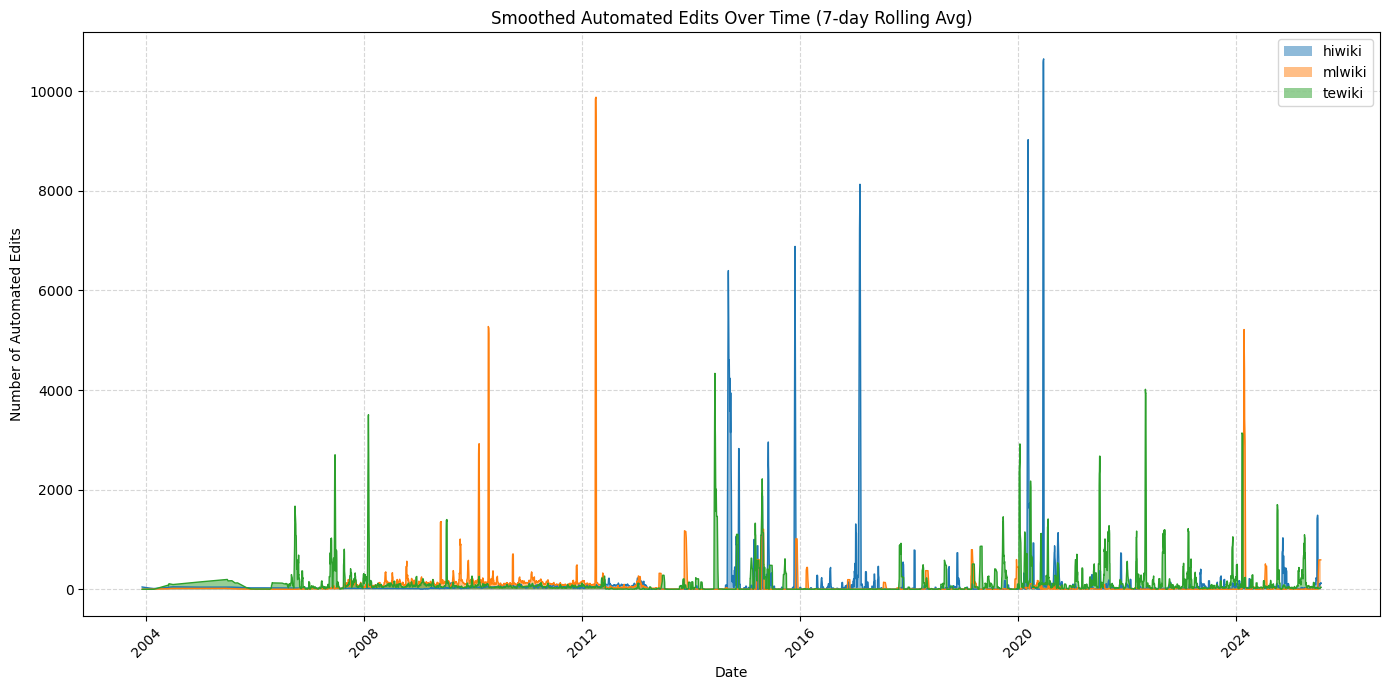

In [93]:
# ------------------ Fetch and clean SQL ------------------
response = requests.get(query_url2)
if response.status_code != 200:
    raise Exception(f"Failed to fetch query from {query_url}. Status code: {response.status_code}")

query_raw = response.text.strip()
cleaned_query = sqlparse.format(query_raw, strip_comments=True, reindent=False).strip()

if not cleaned_query:
    raise ValueError("SQL query is empty after cleaning. Please check the query content or URL.")

# ------------------ Execute the query across all wikis ------------------
all_dfs = []
for wiki in wikis:
    print(f"Querying: {wiki}")
    try:
        df = connect_and_query(wiki, query2)
        df['wiki'] = wiki
        all_dfs.append(df)
    except Exception as e:
        print(f"Could not run query on {wiki}: {e}")

# ------------------ Combine and visualize results ------------------
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df['Edit_Date'] = pd.to_datetime(combined_df['Edit_Date'])  # Ensure datetime type

    # ------------------ Fill Between Visualization ------------------
    plt.figure(figsize=(14, 7))
    for wiki_name, group in combined_df.groupby('wiki'):
        group = group.sort_values('Edit_Date')
        group['Smoothed_Edits'] = group['Automated_Edits'].rolling(window=7, min_periods=1).mean()
        plt.fill_between(group['Edit_Date'], group['Smoothed_Edits'], alpha=0.5, label=wiki_name)
        plt.plot(group['Edit_Date'], group['Smoothed_Edits'], linewidth=1)
    
    plt.title("Smoothed Automated Edits Over Time (7-day Rolling Avg)")
    plt.xlabel("Date")
    plt.ylabel("Number of Automated Edits")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


else:
    print("\nNo data was fetched from any wiki.")

Number_of_edits_deleted,reverted_or_rollback

In [69]:
query_url3 = "https://raw.githubusercontent.com/yeswanth120-gif/community-insights-dashboard-tooling/main/Number_of_edits_deleted,reverted_or_rollback.sql"
query3 = requests.get(query_url3).text

In [70]:
query3

"SELECT\n    DATE(r.rev_timestamp) AS Edit_Date,              -- Extracts the date for dashboard filtering\n    COUNT(DISTINCT r.rev_id) AS reverted_edits       -- Counts the number of unique reverted edits\nFROM\n    revision AS r\nJOIN\n    change_tag AS ct ON r.rev_id = ct.ct_rev_id      -- Links revisions to their associated tags\nJOIN\n    change_tag_def AS ctd ON ct.ct_tag_id = ctd.ctd_id -- Gets the name of the tag\nWHERE\n    ctd.ctd_name IN ('mw-reverted', 'mw-rollback', 'mw-undo') -- Filters for specific revert, rollback, and undo tags\nGROUP BY\n    Edit_Date                                        -- Groups the daily counts\nORDER BY\n    Edit_Date;                                       -- Sorts the results chronologically\n"

Running query on tewiki...
Running query on hiwiki...
Running query on mlwiki...


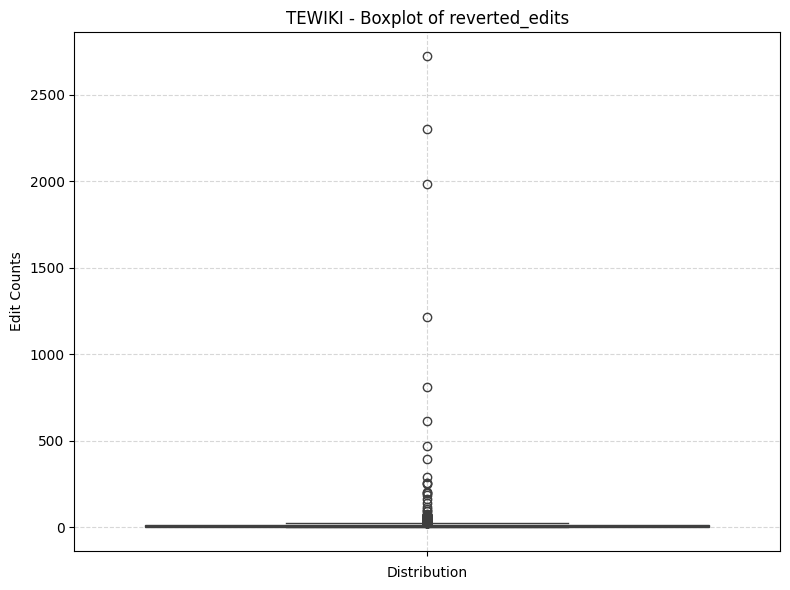

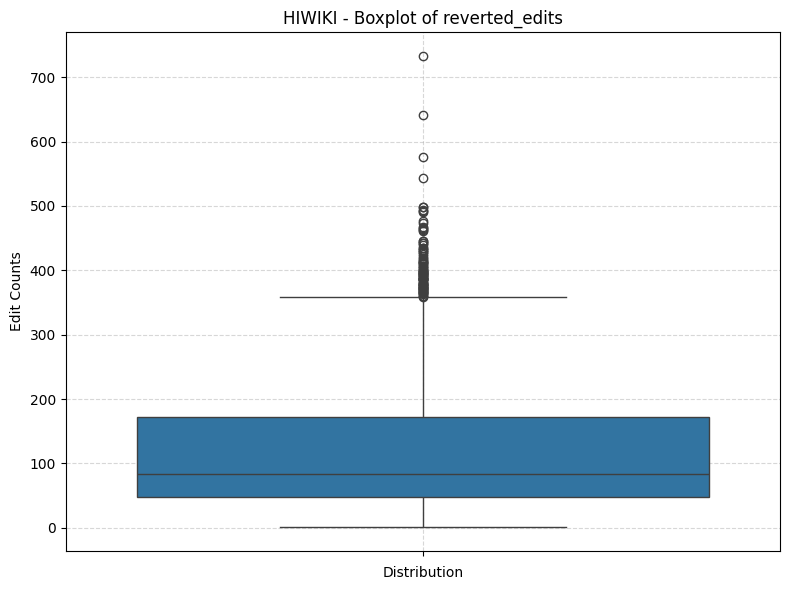

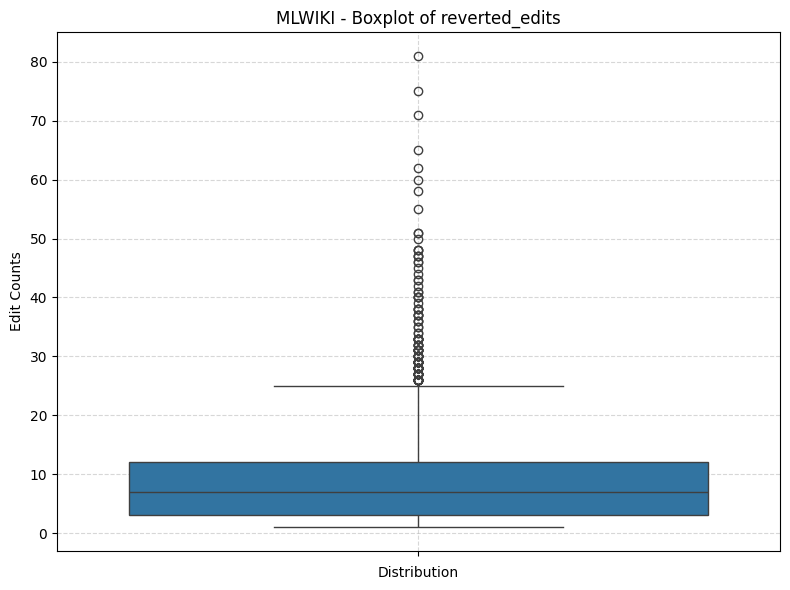

In [98]:
response = requests.get(query_url3)
if response.status_code != 200:
    raise Exception(f"Failed to fetch query from {query_url}. Status code: {response.status_code}")

query_raw = response.text.strip()
cleaned_query = sqlparse.format(query_raw, strip_comments=True, reindent=False).strip()
if not cleaned_query:
    raise ValueError("SQL query is empty after cleaning.")

# ------------------ Run Query Across Wikis ------------------
all_dfs = []
for wiki in wikis:
    print(f"Running query on {wiki}...")
    try:
        df = connect_and_query(wiki, cleaned_query)
        df['wiki'] = wiki
        all_dfs.append(df)
    except Exception as e:
        print(f"Could not run query on {wiki}: {e}")

# ------------------ Plot Box Plots ------------------
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Ensure correct column names and types
    combined_df['Edit_Date'] = pd.to_datetime(combined_df['Edit_Date'])
    value_col = [col for col in combined_df.columns if col not in ['Edit_Date', 'wiki']][0]

    for wiki_name in combined_df['wiki'].unique():
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=combined_df[combined_df['wiki'] == wiki_name], y=value_col)
        plt.title(f"{wiki_name.upper()} - Boxplot of {value_col}")
        plt.ylabel("Edit Counts")
        plt.xlabel("Distribution")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

else:
    print("No data fetched from any wiki.")